In [23]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rioxr
from dask.distributed import Client, LocalCluster, Lock
from tqdm.notebook import tqdm
import sys
import gc
from rioxarray.merge import merge_arrays
import geopandas as gpd
from datetime import datetime, date, timedelta
import skimage.measure
import seaborn as sns
from dask.distributed import Client, LocalCluster, Lock
import warnings

warnings.filterwarnings("ignore")

##### -----------------------<i>This code is runnable-------------------------


### First part of code is for processing test data (one tile, by year)
### Second part of code is for processing all data (all tiles, by year)

In [9]:
# getting list of BP tifs for one tile
# reading in df with metadata info (most importantly, date and DOY)

dir = "C:/Users/rmonaghan/Desktop/SE_Firemap_Date/BA_C2_CU_Test_Data/h024v016/scene_BP"
tifs = np.array(
    [
        os.path.join(r, file).replace("\\", "/")
        for r, d, f in os.walk(dir)
        for file in f
        if file.upper().endswith(".TIF")
    ]
)

stack_df_path = "F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Burn_Permits/SE_Firemap_Date/BA_C2_CU_Test_Data/h024v016/stack.csv"
stack_df = pd.read_csv(stack_df_path)  # will depend on data root dir

root_dir = "F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Burn_Permits/SE_Firemap_Date/BA_C2_CU_Test_Data/h024v016/scene_BP/"
stack_df["filename"] = root_dir + stack_df["FILE"] + "_BP.tif"
len(stack_df), len(tifs), stack_df.columns

(1989,
 1989,
 Index(['FILE', 'HH', 'VV', 'PATH', 'ROW', 'SENSOR', 'YEAR', 'MONTH', 'DAY',
        'JULIAN', 'CLOUD_COVER', 'CLOUD_SHADOW_COVER', 'SNOW_ICE', 'FILL',
        'INSTRUMENT', 'ACQUISITION_DATE', 'PRODUCTION_DATE', 'RMSE', 'PROCESS',
        'OUTPUT', 'filename'],
       dtype='object'))

In [83]:
stack_df.head()

FILE  HH  VV  PATH  ROW  SENSOR  YEAR  \
0  LT05_CU_024016_19840410_20210421_02  24  16   NaN  NaN       5  1984   
1  LT05_CU_024016_19840503_20210421_02  24  16   NaN  NaN       5  1984   
2  LT05_CU_024016_19840519_20210421_02  24  16   NaN  NaN       5  1984   
3  LT05_CU_024016_19840604_20210421_02  24  16   NaN  NaN       5  1984   
4  LT05_CU_024016_19840613_20210421_02  24  16   NaN  NaN       5  1984   

   MONTH  DAY  JULIAN  ...  CLOUD_SHADOW_COVER  SNOW_ICE     FILL  INSTRUMENT  \
0      4   10     101  ...             30.1576    0.0244  14.6912          TM   
1      5    3     124  ...             17.5499    0.3236  53.2881          TM   
2      5   19     140  ...              4.0735    0.0006  57.2444          TM   
3      6    4     156  ...              0.0961    0.0000  59.1248          TM   
4      6   13     165  ...              9.3980    0.0052  27.7094          TM   

  ACQUISITION_DATE       PRODUCTION_DATE   RMSE  PROCESS  OUTPUT  \
0       1984-04-10  2021-04-21T18:35:23Z  7.907        1       1   
1       1984-05-03  2021-04-21T19:08:03Z  9.285        1       1   
2       1984-05-19  2021-04-21T20:45:33Z  5.112        1       1   
3       1984-06-04  2021-04-21T21:09:12Z  5.622        1       1   
4       1984-06-13  2021-04-21T21:01:37Z  7.975        1       1   

                                            filename  
0  F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Bur...  
1  F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Bur...  
2  F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Bur...  
3  F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Bur...  
4  F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Bur...  

[5 rows x 21 columns]

In [4]:
# to generate a similar df from filenames

# stack_df = pd.DataFrame({'filename':tifs})
# stack_df['AcqDT'] = pd.to_datetime(stack_df['filename'].str.slice(95, -19))
# stack_df['AcqDT_str'] = stack_df['filename'].str.slice(95, -19)
# stack_df.sort_values('AcqDT_str', inplace=True)
# stack_df['year'] = stack_df['AcqDT'].dt.year
# stack_df['doy'] =stack_df['AcqDT'].dt.dayofyear
# stack_df.sort_values('AcqDT', inplace=True)
# stack_df

In [29]:
############################################# FOR PROCESSING FILES IN ONLY ONE DIRECTORY  ######################################################


# function that details errors
def get_e():
    exception_type, exception_object, exception_traceback = sys.exc_info()
    filename = exception_traceback.tb_frame.f_code.co_filename
    line_number = exception_traceback.tb_lineno

    e = Exception
    print("Error:", e)
    print("Exception type: ", exception_type)
    print("File name: ", filename)
    print("Line number: ", line_number)


# subsets based on year
def subset(df, year, annual_fp):
    try:
        df_subset = df.query(f"YEAR == {year}").copy().sort_values("JULIAN")
        cols = (
            df_subset["filename"],
            df_subset["ACQUISITION_DATE"].astype(str).str.replace("-", ""),
            df_subset["JULIAN"],
        )
        filenames, dates, doys = [i.to_list() for i in cols]

        if locals()["annual_fp"] is not None:
            patches = rioxr.open_rasterio(
                annual_fp + f"/BurnedArea_{year}_90BP_SE.tif", mask_and_scale=True
            )
            return filenames, dates, doys, patches
        else:
            return filenames, dates, doys
    except:
        print("function subset_df", get_e())


# get dates based on if product/output desired is last clear pixel ("LCP"/"NB"--for "not burn") or date of first burn detection ("BD")
def get_dates(type, filenames, dates, doys, flag, threshold):
    type = locals()["type"]
    rasters = []

    try:
        with tqdm(total=len(filenames)) as pbar:
            for file, date, doy in zip(filenames, dates, doys):
                ds = rioxr.open_rasterio(file, mask_and_scale=True).squeeze("band")

                dt = int(date)
                ds["DT"] = dt
                ds = ds.assign_coords({"DT": date}).expand_dims("DT")

                if type == "NB":
                    ds.data = np.where(
                        (ds.data <= flag) & (ds.data < threshold), dt, np.nan
                    )
                    rasters.append(ds)
                    pbar.update(1)

                elif type == "BD":
                    ds.data = np.where(
                        (ds.data <= flag) & (ds.data >= threshold), dt, np.nan
                    )
                    rasters.append(ds)
                    pbar.update(1)

        if type == "NB":
            return xr.combine_by_coords(
                rasters
            )  # returns not burn date values per each date
        elif type == "BD":
            return xr.combine_by_coords(rasters).min(
                "DT"
            )  # returns the minimum burn date across all scenes
    except:
        print("function get_date", get_e())


# get last clear pixel
def get_LCP(BD, NB, year, df, threshold, flag):
    try:
        lcp = NB.where(NB < BD).max(
            "DT"
        )  # look only where not burn stack is less than burn date, then get the max across time
        lcp.data = np.where(BD.data, lcp.data, np.nan)

        leftover = BD.copy()
        leftover.data = np.where(
            lcp > 0, np.nan, leftover.data
        )  # look for where there has been no lcp available for subsetted year

        # run NB for year previous, get the closest to the end of the year
        filenames_lastyear, dates_lastyear, doys_lastyear = subset(df, year - 1, None)
        nb_lastyear = get_dates(
            "NB", filenames_lastyear, dates_lastyear, doys_lastyear, flag, threshold
        )
        nb_lastyear = nb_lastyear.where(nb_lastyear < BD).max("DT")
        nb_lastyear.data = np.where(leftover.data > 0, nb_lastyear.data, np.nan)

        # merge last year LCP and this year LCP
        lcp_main = merge_arrays([lcp.fillna(0), nb_lastyear.fillna(0)])
        lcp_main.data = np.where(lcp.data == 0, np.nan, lcp.data)

        return lcp_main

    except:
        print("function get_LCP", get_e())


# calculate mode for an array -- did not use nanargmax
def mode(x):
    vals, counts = np.unique(x, return_counts=True)
    mode_idx = np.argmax(counts)
    return vals[mode_idx]


# returns grouped object
def group_and_return(patch_raster, data_raster, name):
    try:
        sub = (
            patch_raster.where(patch_raster == 1)
            .squeeze("band")
            .sel(x=data_raster.x, y=data_raster.y)
            .fillna(0)
            .astype("int32")
        )
        labeled = skimage.measure.label(sub.data, connectivity=2, background=0)
        labeled_da = xr.DataArray(
            labeled, coords={"y": sub.y, "x": sub.x}, dims={"y": sub.y, "x": sub.x}
        )

        merged = labeled_da.where(labeled_da > 0).to_dataset(name="labels")
        merged[f"{name}"] = (
            data_raster.dims,
            data_raster.values,
            data_raster.attrs,
            data_raster.encoding,
        )
        grouped = merged[f"{name}"].groupby(merged["labels"], restore_coord_dims=True)

        return grouped, labeled_da

    except:
        print("function group_and_return", get_e())


# computes zonal statistics and outputs raster with majority date
def zonal_stats(grouped, labeled_raster, crs_raster, year):
    crs = crs_raster.rio.crs

    try:
        modes = []
        for group in grouped:
            filt = group[1].data
            filt_notnan = filt[~np.isnan(filt)]
            if filt_notnan.size > 0:
                majority = mode(filt_notnan)
                modes.append((majority, group[0]))

        labeled_raster.data = np.where(
            labeled_raster.data == 0, np.nan, labeled_raster.data
        )
        fillin_arr = labeled_raster.data
        for val, label in modes:
            fillin_arr[fillin_arr == label] = val

        zstats = xr.DataArray(
            fillin_arr,
            coords={"y": labeled_raster.y, "x": labeled_raster.x},
            dims={"y": labeled_raster.y, "x": labeled_raster.x},
        )
        zstats = zstats.fillna(32767)
        zstats.rio.write_nodata(32767, inplace=True)
        zstats.rio.write_crs(bd.rio.crs)
        zstats = zstats.astype(int)

        min_date = (year - 1) * (10**4) # this bit of code has caused issues
        zstats.data = np.where(
            ((zstats.data != zstats.rio.nodata) & (zstats.data < min_date)),
            0,
            zstats.data,
        )

        return zstats
    except:
        print("function zonal_stats", get_e())

In [30]:
year = 2017
annual_fp = "F:/RMonaghan_Workspace/Projects_Main/GM/SE_Firemap_BD_LCP/Annual_Rasters"
threshold = 90
flag = 249
df = stack_df

filenames, dates, doys, patches = subset(stack_df, year, annual_fp)

bd = get_dates("BD", filenames, dates, doys, flag, threshold)
nb = get_dates("NB", filenames, dates, doys, flag, threshold)
lcp = get_LCP(bd, nb, year, df, threshold, flag)

bd_grouped, labeled_da = group_and_return(patches, bd, "BD")
bd_zstats = zonal_stats(year, bd_grouped, labeled_da, patches)

lcp_grouped, labeled_da = group_and_return(patches, lcp, "LCP")
lcp_zstats = zonal_stats(year, lcp_grouped, labeled_da, patches)

### processing at 17 minutes for one year/one tile

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [31]:
# Looking at "fire windows" for 2017

min_date = (year - 1) * (10**4)
names = ["bd", "lcp"]
ds_lis = [
    bd,
    lcp,
]
lcp_zstats.data = np.where(
    ((lcp_zstats.data != lcp_zstats.rio.nodata) & (lcp_zstats.data < min_date)),
    0,
    lcp_zstats.data,
)

In [32]:
lcp_df = lcp.to_dataframe(name="lcp")
bd_df = bd.to_dataframe(name="bd")

lcp_df = lcp_df.reset_index()
bd_df = bd_df.reset_index()

merged = lcp_df.merge(bd_df, on=["x", "y", "band", "spatial_ref"])
merged = merged.dropna()

merged["lcp_dt"] = pd.to_datetime(merged["lcp"], format="%Y%m%d")
merged["bd_dt"] = pd.to_datetime(merged["bd"], format="%Y%m%d")

merged["fwindow"] = fwindow = merged["bd_dt"] - merged["lcp_dt"]
merged["fwindow_days"] = merged["fwindow"].dt.days

In [33]:
merged["fwindow"].describe()

count                        776337
mean     13 days 00:22:11.050819424
std       8 days 11:55:03.757809017
min                 1 days 00:00:00
25%                 8 days 00:00:00
50%                 8 days 00:00:00
75%                16 days 00:00:00
max               280 days 00:00:00
Name: fwindow, dtype: object

In [34]:
sns.boxplot(data=merged, x=merged["fwindow_days"], palette="viridis", color="blue")

<Axes: xlabel='fwindow_days'>

<Axes: xlabel='fwindow_days', ylabel='Count'>

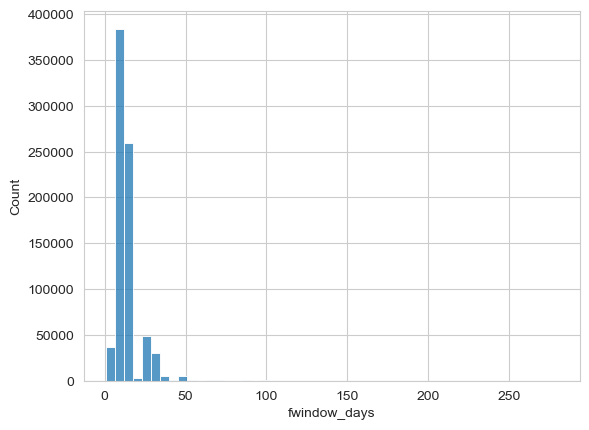

In [35]:
sns.histplot(data=merged, x=merged["fwindow_days"], bins=50)

In [10]:
############################## FOR PROCESSING FILES FROM MANY SUBDIRECTORIES ##################################

scan_dir = "F:/Projects/SE_Fire_Map/USGS_Data"

stacks = []
for r, d, f in os.walk(scan_dir):
    for file in f:
        if "stack_qa.csv" in file:
            stacks.append(os.path.join(r, file).replace("\\", "/"))

print(len(stacks))
stacks

57


['F:/Projects/SE_Fire_Map/USGS_Data/h017v016/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h017v017/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h017v018/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h018v015/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h018v016/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h018v017/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h019v015/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h019v016/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h019v017/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h020v015/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h020v016/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h020v017/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h021v014/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h021v015/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h021v016/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h021v017/stack_qa.csv',
 'F:/Projects/SE_Fire_Map/USGS_Data/h022

In [12]:
# function that details errors
def get_e():
    exception_type, exception_object, exception_traceback = sys.exc_info()
    filename = exception_traceback.tb_frame.f_code.co_filename
    line_number = exception_traceback.tb_lineno

    e = Exception
    print("Error:", e)
    print("Exception type: ", exception_type)
    print("File name: ", filename)
    print("Line number: ", line_number)


# function that subsets qa stack and annual composite
def subset(stack, year, annual_fp):
    try:
        df = pd.read_csv(stack)
        df_subset = df.query(f"YEAR == {year}").copy().sort_values("JULIAN")
        df_subset["filename"] = [
            stack.replace("stack_qa.csv", "scene_BP/") + i
            for i in df_subset["FILE"] + "_BP.tif"
        ]
        cols = (
            df_subset["filename"],
            df_subset["ACQUISITION_DATE"].astype(str).str.replace("-", ""),
            df_subset["JULIAN"],
        )
        filenames, dates, doys = [i.to_list() for i in cols]

        if locals()["annual_fp"] is not None:
            patches = rioxr.open_rasterio(
                annual_fp + f"/BurnedArea_{year}_90BP_SE.tif", mask_and_scale=True
            )
            return filenames, dates, doys, patches
        else:
            return filenames, dates, doys
    except:
        print("function subset_df", get_e())


# get dates based on if product/output desired is last clear pixel ("LCP"/"NB"--for "not burn") or date of first burn detection ("BD")
def get_dates(type, filenames, dates, doys, flag, threshold):
    type = locals()["type"]
    rasters = []

    try:
        for file, date, doy in zip(filenames, dates, doys):
            ds = rioxr.open_rasterio(file, mask_and_scale=True).squeeze("band")

            dt = int(date)
            ds["DT"] = dt
            ds = ds.assign_coords({"DT": date}).expand_dims("DT")

            if type == "NB":
                ds.data = np.where(
                    (ds.data <= flag) & (ds.data < threshold), dt, np.nan
                )
                rasters.append(ds)
            elif type == "BD":
                ds.data = np.where(
                    (ds.data <= flag) & (ds.data >= threshold), dt, np.nan
                )
                rasters.append(ds)

        if type == "NB":
            return xr.combine_by_coords(
                rasters
            )  # returns not burn date values per each date
        elif type == "BD":
            return xr.combine_by_coords(rasters).min(
                "DT"
            )  # returns the minimum burn date across all scenes
    except:
        print("function get_date", get_e())


# get last clear pixel
def get_LCP(BD, NB, year, stack, threshold, flag):
    try:
        lcp = NB.where(NB < BD).max(
            "DT"
        )  # look only where not burn stack is less than burn date, then get the max across time
        lcp.data = np.where(BD.data, lcp.data, np.nan)

        leftover = BD.copy()
        leftover.data = np.where(
            lcp > 0, np.nan, leftover.data
        )  # look for where there has been no lcp available for subsetted year

        # run NB for year previous, get the closest to the end of the year
        filenames_lastyear, dates_lastyear, doys_lastyear = subset(
            stack, year - 1, None
        )
        nb_lastyear = get_dates(
            "NB", filenames_lastyear, dates_lastyear, doys_lastyear, flag, threshold
        )
        nb_lastyear = nb_lastyear.where(nb_lastyear < BD).max("DT")
        nb_lastyear.data = np.where(leftover.data > 0, nb_lastyear.data, np.nan)

        # merge last year LCP and this year LCP
        lcp_main = merge_arrays([lcp.fillna(0), nb_lastyear.fillna(0)])
        lcp_main.data = np.where(lcp.data == 0, np.nan, lcp.data)

        return lcp_main

    except:
        print("function get_LCP", get_e())


# calculate mode for an array -- did not use nanargmax
def mode(x):
    vals, counts = np.unique(x, return_counts=True)
    mode_idx = np.argmax(counts)
    return vals[mode_idx]


# returns grouped object
def group_and_return(patch_raster, data_raster, name):
    try:
        sub = (
            patch_raster.where(patch_raster == 1)
            .squeeze("band")
            .sel(x=data_raster.x, y=data_raster.y)
            .fillna(0)
            .astype("int32")
        )
        labeled = skimage.measure.label(sub.data, connectivity=2, background=0)
        labeled_da = xr.DataArray(
            labeled, coords={"y": sub.y, "x": sub.x}, dims={"y": sub.y, "x": sub.x}
        )

        merged = labeled_da.where(labeled_da > 0).to_dataset(name="labels")
        merged[f"{name}"] = (
            data_raster.dims,
            data_raster.values,
            data_raster.attrs,
            data_raster.encoding,
        )
        grouped = merged[f"{name}"].groupby(merged["labels"], restore_coord_dims=True)

        return grouped, labeled_da

    except:
        print("function group_and_return", get_e())


# computes zonal statistics and outputs raster with majority date
def zonal_stats(grouped, labeled_raster, crs_raster):
    crs = crs_raster.rio.crs

    try:
        modes = []
        for group in grouped:
            filt = group[1].data
            filt_notnan = filt[~np.isnan(filt)]
            if filt_notnan.size > 0:
                majority = mode(filt_notnan)
                modes.append((majority, group[0]))

        labeled_raster.data = np.where(
            labeled_raster.data == 0, np.nan, labeled_raster.data
        )
        fillin_arr = labeled_raster.data
        for val, label in modes:
            fillin_arr[fillin_arr == label] = val

        zstats = xr.DataArray(
            fillin_arr,
            coords={"y": labeled_raster.y, "x": labeled_raster.x},
            dims={"y": labeled_raster.y, "x": labeled_raster.x},
        )
        zstats = zstats.fillna(32767)
        zstats.rio.write_nodata(32767, inplace=True)
        zstats.rio.write_crs(bd.rio.crs)
        zstats = zstats.astype(int)

        min_date = (year - 1) * (10**4)
        zstats.data = np.where(
            ((zstats.data != zstats.rio.nodata) & (zstats.data < min_date)),
            0,
            zstats.data,
        )

        return zstats
    except:
        print("function zonal_stats", get_e())

In [13]:
years = np.arange(1995, 1996, 1)
annual_fp = "F:/RMonaghan_Workspace/Projects_Main/GM/SE_Firemap_BD_LCP/Annual_Rasters"
threshold = 90
flag = 249

outputs = []

for year in years:
    print(f"Working on year {year}")
    try:
        for stack in stacks:
            filenames, dates, doys, patches = subset(stack, year, annual_fp)

            bd = get_dates("BD", filenames, dates, doys, flag, threshold)
            nb = get_dates("NB", filenames, dates, doys, flag, threshold)

            lcp = get_LCP(bd, nb, year, stack, threshold, flag)

            lcp_grouped, labeled_da = group_and_return(patches, lcp, "LCP")
            lcp_zstats = zonal_stats(lcp_grouped, labeled_da, patches)
            outputs.append((year, bd_zstats, lcp_zstats))
    except Exception as e:
        print(e)
        pass

### this script went from taking 11 mins to roughly 2 hours--unsure of the issue

Working on year 1995


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Error: <class 'Exception'>
Exception type:  <class 'ValueError'>
File name:  C:\Users\rmonaghan\AppData\Local\Temp\ipykernel_4660\4187500249.py
Line number:  96
function group_and_return None
cannot unpack non-iterable NoneType object


In [27]:
bd_lis = [i[1] for i in outputs]
bds_combined = xr.combine_by_coords((bd_lis))
bds_combined = bds_combined.fillna(32767)
bds_combined.rio.write_crs(bd.rio.crs, inplace=True)
bds_combined = bds_combined.astype("int32")

In [28]:
with LocalCluster() as cluster, Client(cluster) as client:
    bds_combined.rio.to_raster(
        "F:/RMonaghan_Workspace/Projects_Main/GM/SE_Firemap_BD_LCP/Outputs/Output_BD_1995_test_Projected_3.tif",
        tiled=True,
        lock=Lock("rio", client=client),
    )

### when importing into Arc, double-click raster dataset, and then select "Band_1"--otherwise there is a crs error that gets thrown